# Import Libraries and Functions

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, h5py, gc, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
import concurrent.futures as cf
from pathlib import Path
from torch.utils.data import DataLoader

REPO_ROOT = "../"
proj = Path(REPO_ROOT).resolve()

# allow: import ADCNN.*
sys.path.insert(0, str(proj))

# allow: import utils.*  (where utils == ADCNN/utils)
sys.path.insert(0, str(proj / "ADCNN"))

from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.predict import load_model, predict_tiles_to_full
import ADCNN.evals.basic_evals as evals
import ADCNN.evals.threshold_scan as threshold_scan

test_h5 = "../DATA/test.h5"
test_csv = "../DATA/test.csv"
test_h5_5sigma = "../DATA/5sigma/test.h5"
test_h5_6sigma = "../DATA/6sigma/test.h5"
test_csv_5sigma = "../DATA/5sigma/test.csv"
test_csv_6sigma = "../DATA/6sigma/test.csv"

SAVE_PATH = "../checkpoints/Experiments/"

In [2]:
def calculate_model_metrics (catalog, predictions, ground_truth, best_threshold=None, thr_points=100, stack_fp=None):
    catalog = catalog.copy()
    threshold_df = threshold_scan.scan_thresholds(catalog=catalog, predictions=predictions, ground_truth=ground_truth, stack_fp=stack_fp, n_points=thr_points)
    threshold_scan.plot_fscore(threshold_df["thr"], pix_f1=threshold_df.get("pix_f1"), pix_f2=threshold_df.get("pix_f2"),
                               obj_f1=threshold_df.get("obj_f1"), obj_f2=threshold_df.get("obj_f2"), title="Pixelwise vs Objectwise F-scores")
    threshold_scan.plot_roc(threshold_scan.compute_roc(threshold_df["pix_tp"], threshold_df["pix_fp"], threshold_df["pix_tn"], threshold_df["pix_fn"]))
    threshold_scan.plot_froc(threshold_scan.compute_froc(thr=threshold_df["thr"], obj_tp=threshold_df["obj_tp"], obj_fp=threshold_df["obj_fp"], obj_fn=threshold_df["obj_fn"], n_images=50),
                             title="FROC (objectwise)")
    if best_threshold is None:
        best_threshold = threshold_df["thr"][threshold_df["obj_f2"].argmax()]
    _,_,catalog = evals.confusion_matrix(catalog=catalog, ground_truth= ground_truth,predictions=predictions, stack_fp=stack_fp, threshold=best_threshold, verbose=True)
    _ = evals.plot_detect_hist(catalog, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=" + str(round(best_threshold, 3)))
    _ = evals.plot_detect_hist(catalog, "trail_length", bins=12, title="Detections vs trail length threshold="+ str(round(best_threshold, 3)))
    _ = evals.plot_detect_hist(catalog, "SNR", bins=10, title="Detections vs SNR threshold="+ str(round(best_threshold, 3)), xlim=[0, 10], density=True)
    plt.show()
    return catalog, best_threshold

In [3]:
def load_test_data (h5_path, csv_path, tile=128, k_sigma=5.0, batch_size=128):
    ds_te = H5TiledDataset(h5_path,  tile=tile, k_sigma=k_sigma)
    test_loader = DataLoader(
        ds_te,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        persistent_workers=False,
        prefetch_factor=None,
    )

    test_catalog = pd.read_csv(csv_path)
    with h5py.File(h5_path, "r") as _f:
        gt_test = _f["masks"][:].astype(np.uint8)
        stack_fp = _f["real_labels"][:].astype(np.uint16)
    #print("Test tiles:", len(ds_te))
    return ds_te, test_loader, test_catalog, gt_test, stack_fp

In [4]:
_, test_loader, test_catalog, gt_test, stack_fp = load_test_data(test_h5, test_csv, tile=128, k_sigma=5.0, batch_size=128)

# [2 -10] Sigma Evaluation

## LSST Stack

In [5]:
def get_stack_metrics (catalog, fp_mask):
    tp = (catalog["stack_detection"]==True).sum()
    fn = (catalog["stack_detection"]==False).sum()
    fp = fp_mask.max(axis=(1, 2)).sum()
    return  {"TP": tp, "FP": fp, "FN": fn, "TN": pd.NA}

_, test_loader, test_catalog, gt_test, stack_fp = load_test_data(test_h5, test_csv, tile=128, k_sigma=5.0, batch_size=128)
print ("TEST SET - LSST STACK METRICS")
evals.print_confusion_matrix(get_stack_metrics (test_catalog, stack_fp), title="Object-wise Confusion Matrix")

TEST SET - LSST STACK METRICS
Object-wise Confusion Matrix
F1 Score: 0.0072, F2 Score: 0.0175
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>              133679
Actual Positive                 516                 484



## Baseline Model

In [6]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p_baseline = predict_tiles_to_full(test_h5, test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
del (model_baseline)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_baseline.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


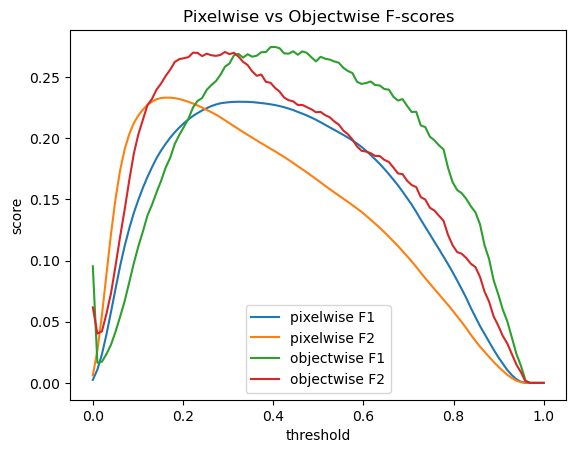

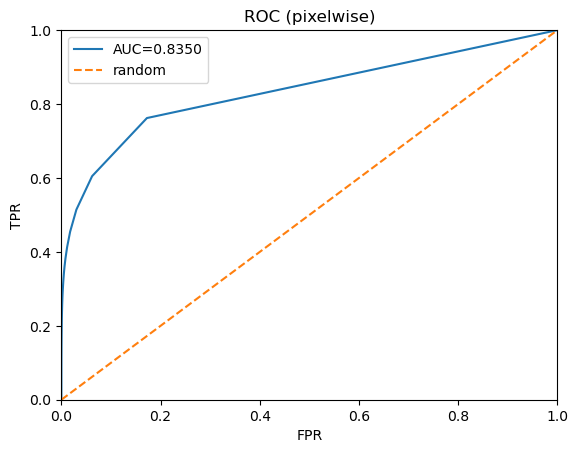

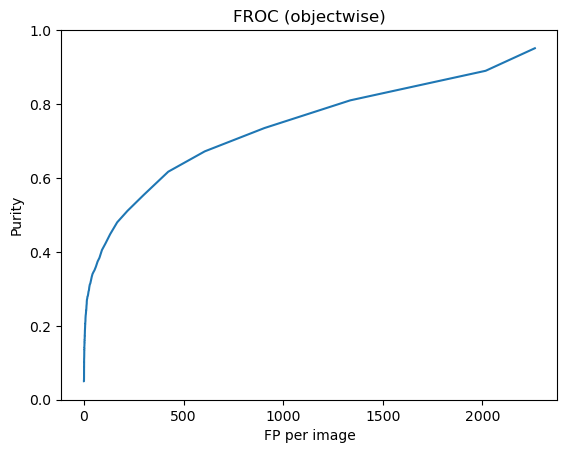

Pixel-wise Confusion Matrix
F1 Score: 0.2289, F2 Score: 0.2145
                 Predicted Negative  Predicted Positive
Actual Negative           812795451              597155
Actual Positive              799982              207412

Object-wise Confusion Matrix
F1 Score: 0.2616, F2 Score: 0.2718
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                 854
Actual Positive                 721                 279



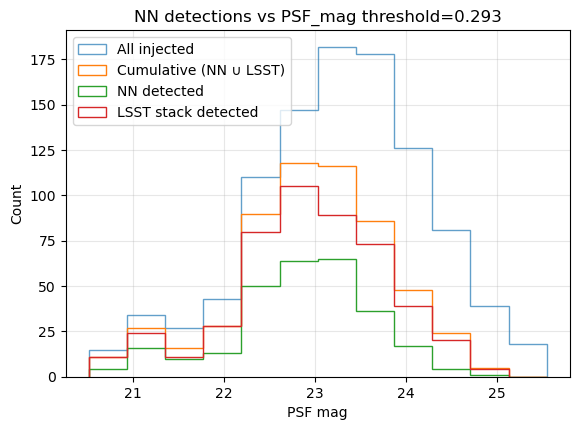

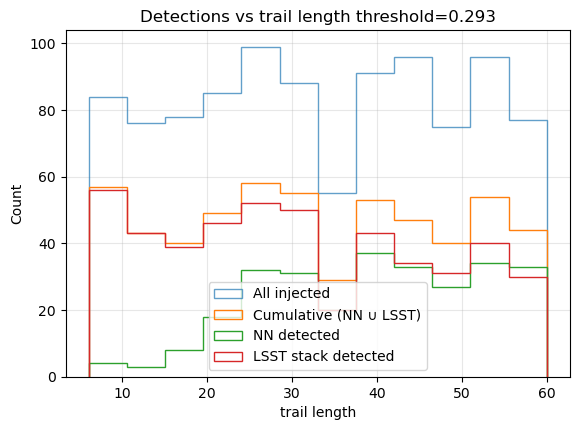

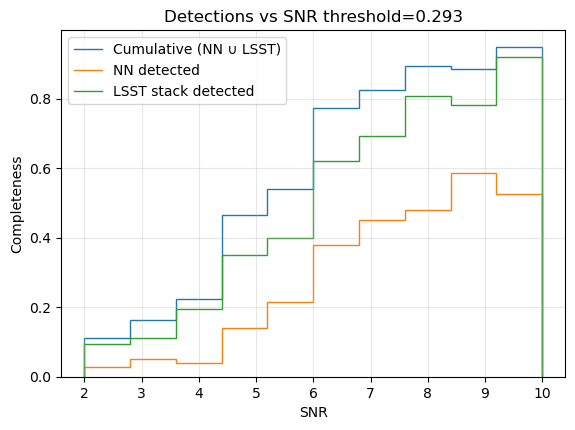

In [7]:
cat_baseline, best_thr = calculate_model_metrics(test_catalog, p_baseline, gt_test, stack_fp=stack_fp)
del (p_baseline, test_loader, test_catalog, gt_test, stack_fp)
_ = gc.collect()
torch.cuda.empty_cache()

# Fixed Sigma Evaluation

## 4 sigma

### LSST Stack

In [9]:
_, test_loader, test_catalog, gt_test, stack_fp = load_test_data("../DATA/4_4s_6_60_l/test.h5",
                                                                 "../DATA/4_4s_6_60_l/test.csv",
                                                                 tile=128, k_sigma=5.0, batch_size=128)
print("5 SIGMA TEST SET - LSST STACK METRICS")
evals.print_confusion_matrix(get_stack_metrics (test_catalog, stack_fp), title="Object-wise Confusion Matrix")

5 SIGMA TEST SET - LSST STACK METRICS
Object-wise Confusion Matrix
F1 Score: 0.0027, F2 Score: 0.0065
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>              133679
Actual Positive                 821                 179



## Baseline Model

In [11]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p = predict_tiles_to_full("../DATA/4_4s_6_60_l/test.h5", test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
del (model_baseline)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


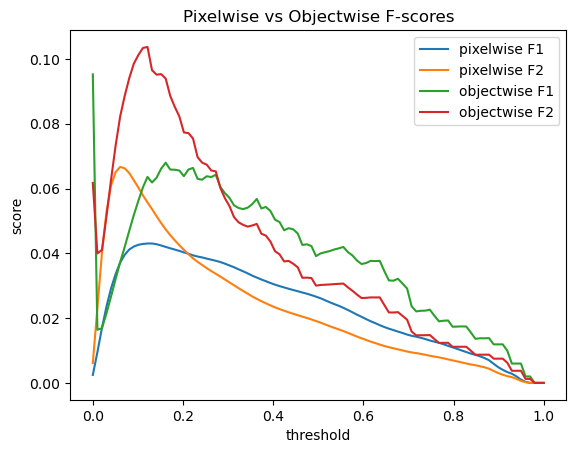

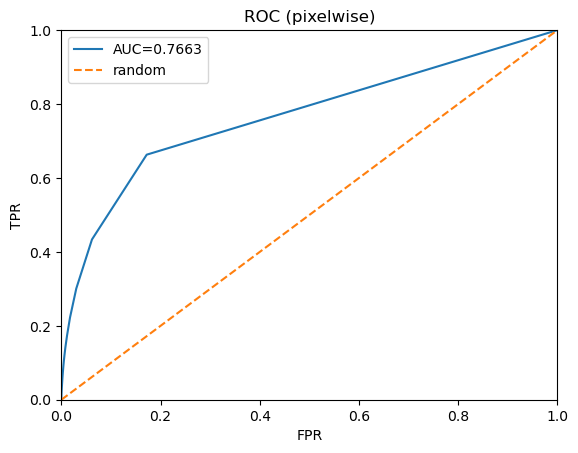

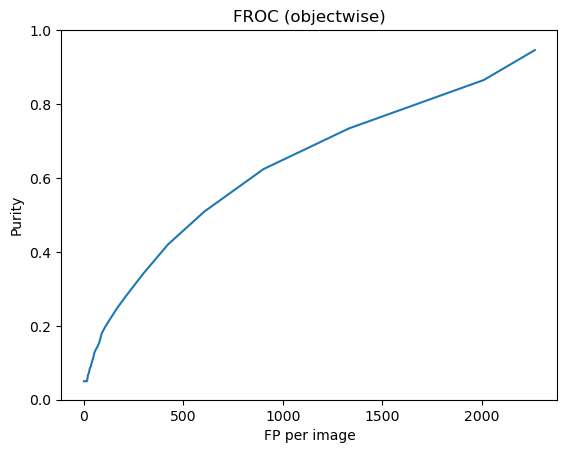

Pixel-wise Confusion Matrix
F1 Score: 0.0368, F2 Score: 0.0319
                 Predicted Negative  Predicted Positive
Actual Negative           812824443              568163
Actual Positive              977854               29540

Object-wise Confusion Matrix
F1 Score: 0.0587, F2 Score: 0.0571
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                 851
Actual Positive                 944                  56



/mnt/Storage/Projects/Asteroid_detection_CNN/ADCNN/evals/basic_evals.py:231: RuntimeWarning: invalid value encountered in divide
  ax.stairs(cum_i/all_i, edges, label="Cumulative (NN ∪ LSST)")
/mnt/Storage/Projects/Asteroid_detection_CNN/ADCNN/evals/basic_evals.py:232: RuntimeWarning: invalid value encountered in divide
  ax.stairs(nn_i/all_i,  edges, label="NN detected")
/mnt/Storage/Projects/Asteroid_detection_CNN/ADCNN/evals/basic_evals.py:233: RuntimeWarning: invalid value encountered in divide
  ax.stairs(stk_i/all_i, edges, label="LSST stack detected")


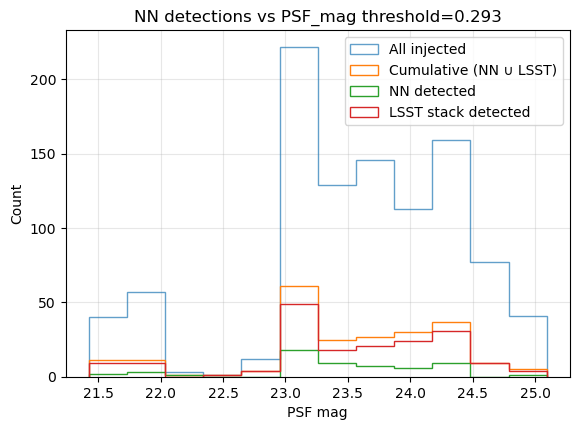

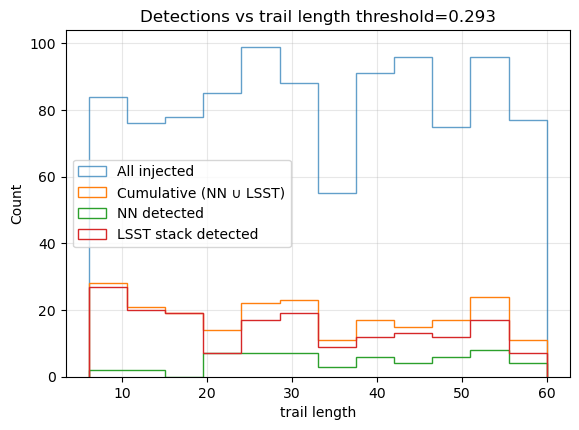

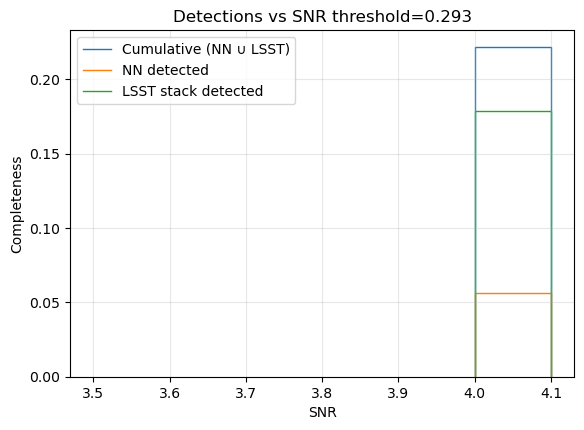

In [12]:
cat, _ = calculate_model_metrics(test_catalog, p, gt_test, best_threshold=best_thr, stack_fp=stack_fp)

## 5 Sigma Evaluation

### LSST Stack

In [15]:
_, test_loader, test_catalog, gt_test, stack_fp = load_test_data("../DATA/5_5s_6_60_l/test.h5",
                                                                 "../DATA/5_5s_6_60_l/test.csv", tile=128, k_sigma=5.0, batch_size=128)
print("5 SIGMA TEST SET - LSST STACK METRICS")
evals.print_confusion_matrix(get_stack_metrics (test_catalog, stack_fp), title="Object-wise Confusion Matrix")

5 SIGMA TEST SET - LSST STACK METRICS
Object-wise Confusion Matrix
F1 Score: 0.0053, F2 Score: 0.0129
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>              133679
Actual Positive                 643                 357



### Baseline Model

In [17]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p= predict_tiles_to_full("../DATA/5_5s_6_60_l/test.h5", test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
del (model_baseline)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


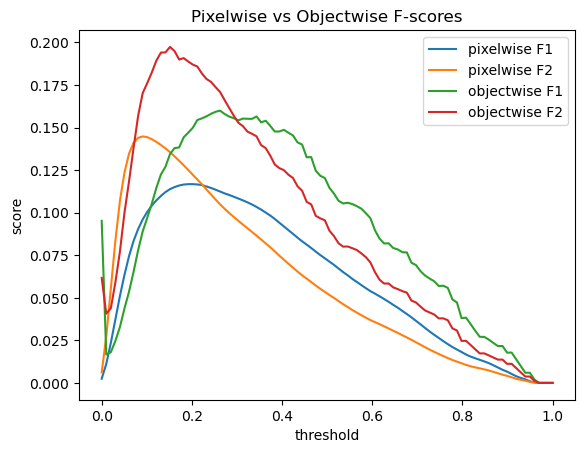

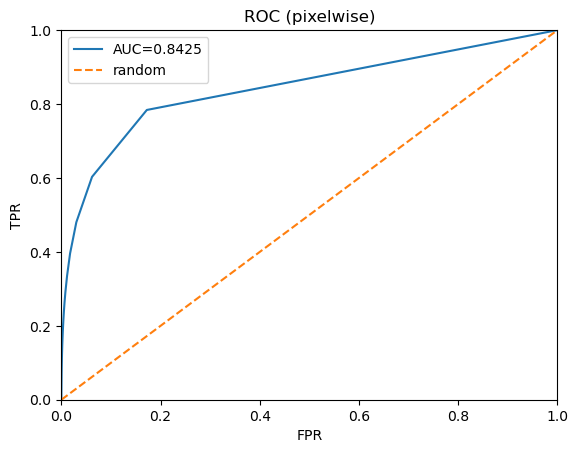

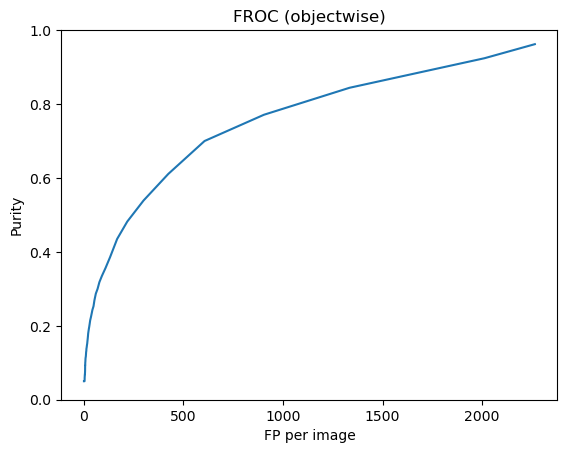

Pixel-wise Confusion Matrix
F1 Score: 0.1094, F2 Score: 0.0975
                 Predicted Negative  Predicted Positive
Actual Negative           812817567              575039
Actual Positive              915858               91536

Object-wise Confusion Matrix
F1 Score: 0.1569, F2 Score: 0.1576
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                 856
Actual Positive                 842                 158



/mnt/Storage/Projects/Asteroid_detection_CNN/ADCNN/evals/basic_evals.py:231: RuntimeWarning: invalid value encountered in divide
  ax.stairs(cum_i/all_i, edges, label="Cumulative (NN ∪ LSST)")
/mnt/Storage/Projects/Asteroid_detection_CNN/ADCNN/evals/basic_evals.py:232: RuntimeWarning: invalid value encountered in divide
  ax.stairs(nn_i/all_i,  edges, label="NN detected")
/mnt/Storage/Projects/Asteroid_detection_CNN/ADCNN/evals/basic_evals.py:233: RuntimeWarning: invalid value encountered in divide
  ax.stairs(stk_i/all_i, edges, label="LSST stack detected")


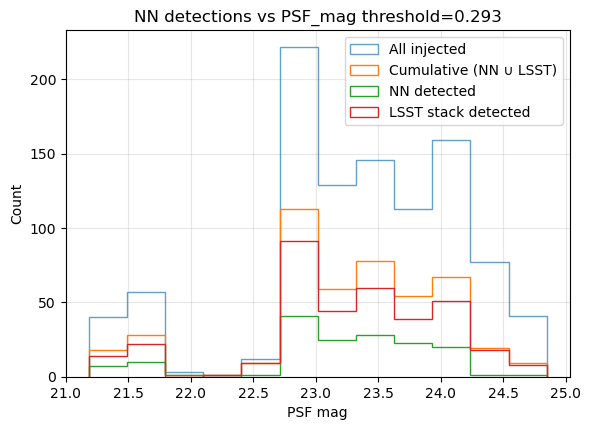

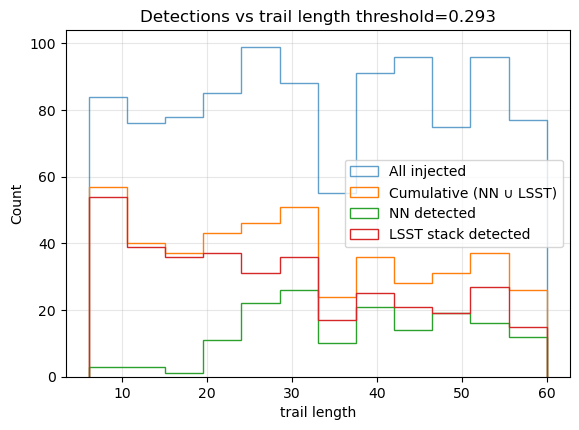

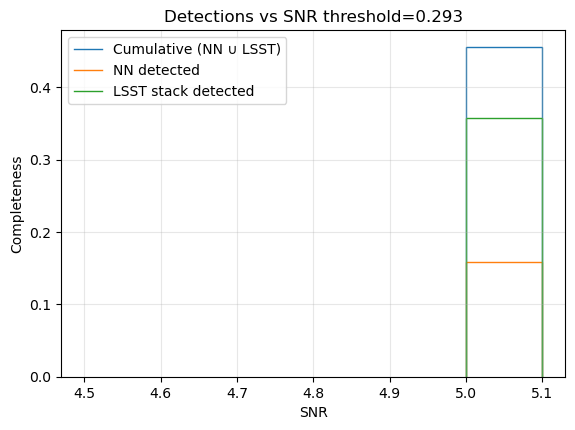

In [18]:
cat, _ = calculate_model_metrics(test_catalog, p, gt_test, best_threshold=best_thr, stack_fp=stack_fp)
#del (p_baseline_6sigma, test_loader_6sigma, test_catalog_6sigma, gt_test_6sigma, stack_fp_6sigma)
#_ = gc.collect()
#torch.cuda.empty_cache()

## 6 Sigma Evaluation

### LSST Stack

In [19]:
_, test_loader, test_catalog, gt_test, stack_fp = load_test_data("../DATA/6_6s_6_60_l/test.h5",
                                                                 "../DATA/6_6s_6_60_l/test.csv", tile=128, k_sigma=5.0, batch_size=128)
print("6 SIGMA TEST SET - LSST STACK METRICS")
evals.print_confusion_matrix(get_stack_metrics (test_catalog, stack_fp), title="Object-wise Confusion Matrix")

6 SIGMA TEST SET - LSST STACK METRICS
Object-wise Confusion Matrix
F1 Score: 0.0078, F2 Score: 0.0190
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>              133679
Actual Positive                 475                 525



### Baseline Model

In [21]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p= predict_tiles_to_full("../DATA/6_6s_6_60_l/test.h5", test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
del (model_baseline)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


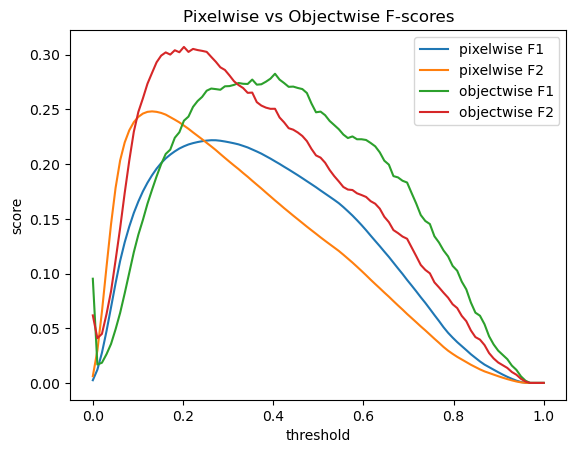

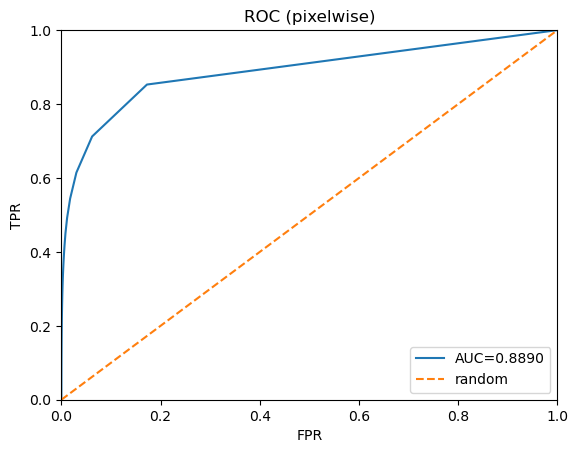

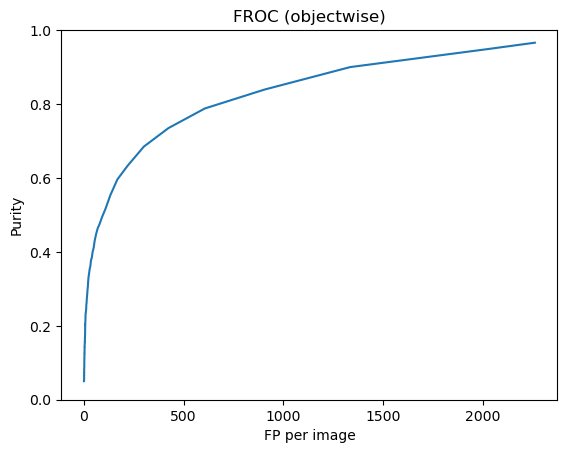

Pixel-wise Confusion Matrix
F1 Score: 0.2207, F2 Score: 0.2056
                 Predicted Negative  Predicted Positive
Actual Negative           812802316              590290
Actual Positive              809244              198150

Object-wise Confusion Matrix
F1 Score: 0.2756, F2 Score: 0.2881
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                 858
Actual Positive                 703                 297



/mnt/Storage/Projects/Asteroid_detection_CNN/ADCNN/evals/basic_evals.py:231: RuntimeWarning: invalid value encountered in divide
  ax.stairs(cum_i/all_i, edges, label="Cumulative (NN ∪ LSST)")
/mnt/Storage/Projects/Asteroid_detection_CNN/ADCNN/evals/basic_evals.py:232: RuntimeWarning: invalid value encountered in divide
  ax.stairs(nn_i/all_i,  edges, label="NN detected")
/mnt/Storage/Projects/Asteroid_detection_CNN/ADCNN/evals/basic_evals.py:233: RuntimeWarning: invalid value encountered in divide
  ax.stairs(stk_i/all_i, edges, label="LSST stack detected")


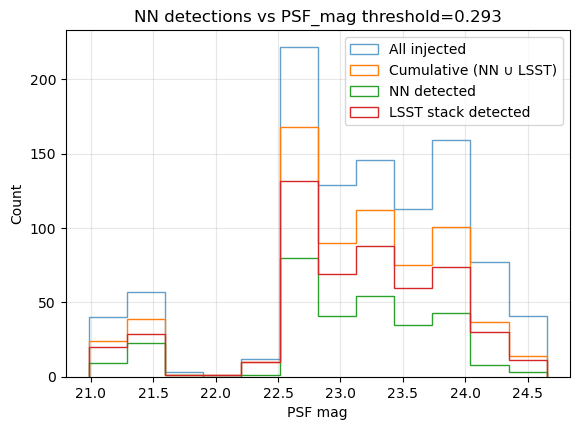

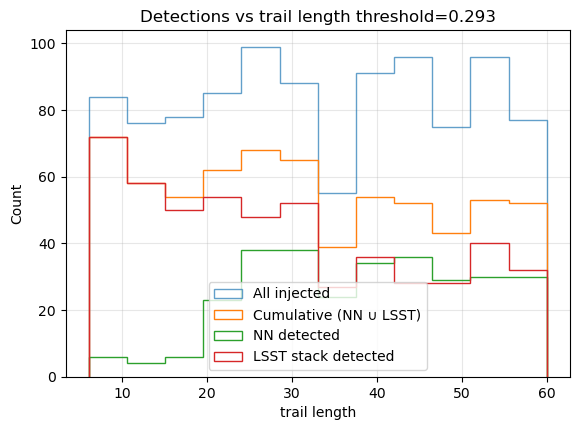

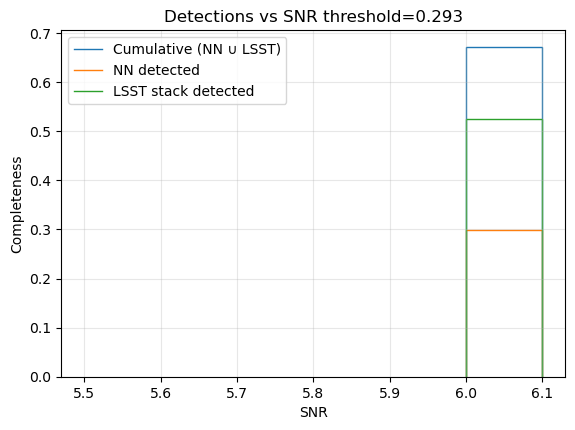

In [22]:
cat, _ = calculate_model_metrics(test_catalog, p, gt_test, best_threshold=best_thr, stack_fp=stack_fp)
#del (p_baseline_6sigma, test_loader_6sigma, test_catalog_6sigma, gt_test_6sigma, stack_fp_6sigma)
#_ = gc.collect()
#torch.cuda.empty_cache()

# Fixed Trail Length Evaluation

## Len = 10 pixels

### LSST Stack

In [24]:
_, test_loader, test_catalog, gt_test, stack_fp = load_test_data("../DATA/2_10s_10_10_l/test.h5",
                                                                 "../DATA/2_10s_10_10_l/test.csv", tile=128, k_sigma=5.0, batch_size=128)
print("6 SIGMA TEST SET - LSST STACK METRICS")
evals.print_confusion_matrix(get_stack_metrics (test_catalog, stack_fp), title="Object-wise Confusion Matrix")

6 SIGMA TEST SET - LSST STACK METRICS
Object-wise Confusion Matrix
F1 Score: 0.0093, F2 Score: 0.0226
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>              133679
Actual Positive                 374                 626



### Baseline Model

In [25]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p= predict_tiles_to_full("../DATA/2_10s_10_10_l/test.h5", test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
del (model_baseline)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


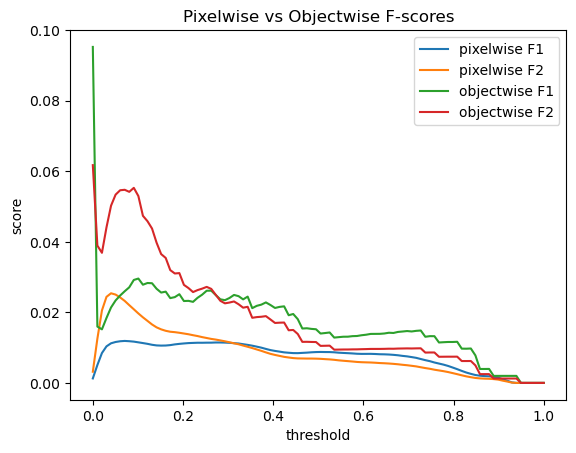

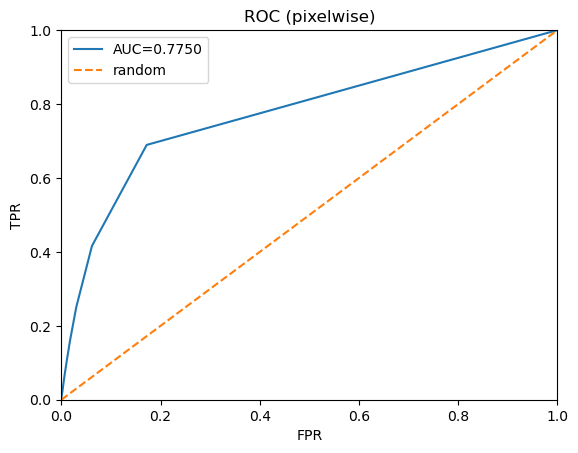

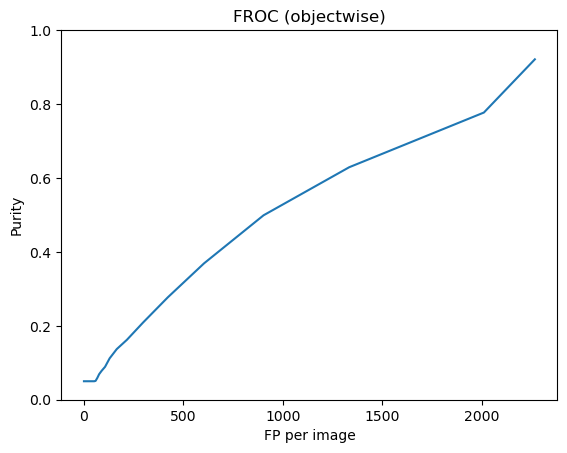

Pixel-wise Confusion Matrix
F1 Score: 0.0114, F2 Score: 0.0118
                 Predicted Negative  Predicted Positive
Actual Negative           813314586              567706
Actual Positive              511469                6239

Object-wise Confusion Matrix
F1 Score: 0.0235, F2 Score: 0.0226
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                 851
Actual Positive                 978                  22



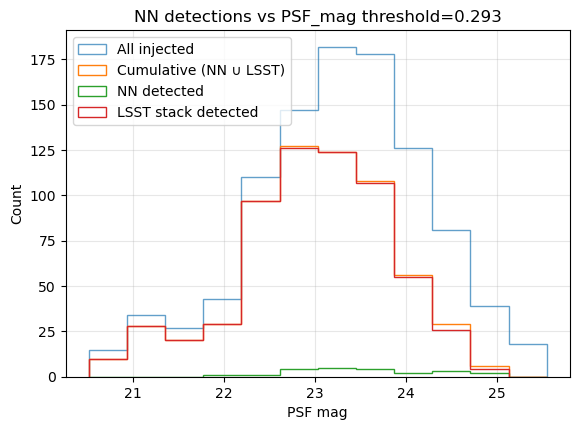

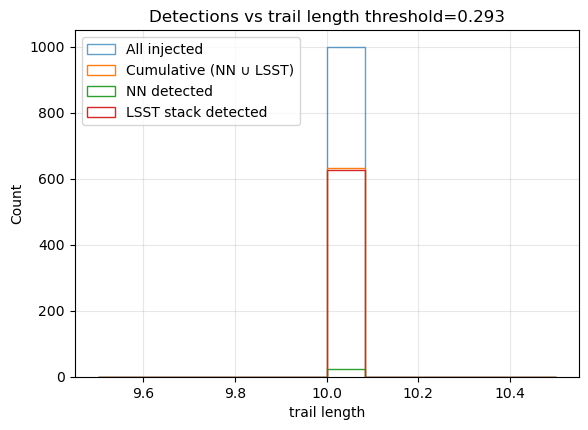

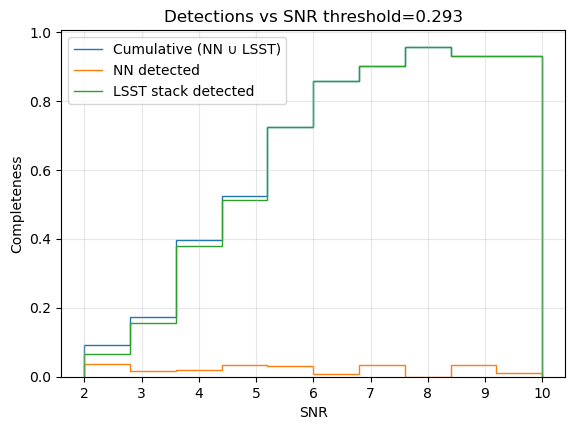

In [26]:
cat, _ = calculate_model_metrics(test_catalog, p, gt_test, best_threshold=best_thr, stack_fp=stack_fp)
#del (p_baseline_6sigma, test_loader_6sigma, test_catalog_6sigma, gt_test_6sigma, stack_fp_6sigma)
#_ = gc.collect()
#torch.cuda.empty_cache()

## Len = 30 pixels

### LSST Stack

In [28]:
_, test_loader, test_catalog, gt_test, stack_fp = load_test_data("../DATA/2_10s_30_30_l/test.h5",
                                                                 "../DATA/2_10s_30_30_l/test.csv", tile=128, k_sigma=5.0, batch_size=128)
print("6 SIGMA TEST SET - LSST STACK METRICS")
evals.print_confusion_matrix(get_stack_metrics (test_catalog, stack_fp), title="Object-wise Confusion Matrix")

6 SIGMA TEST SET - LSST STACK METRICS
Object-wise Confusion Matrix
F1 Score: 0.0072, F2 Score: 0.0176
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>              133679
Actual Positive                 514                 486



### Baseline Model

In [29]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p= predict_tiles_to_full("../DATA/2_10s_30_30_l/test.h5", test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
del (model_baseline)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


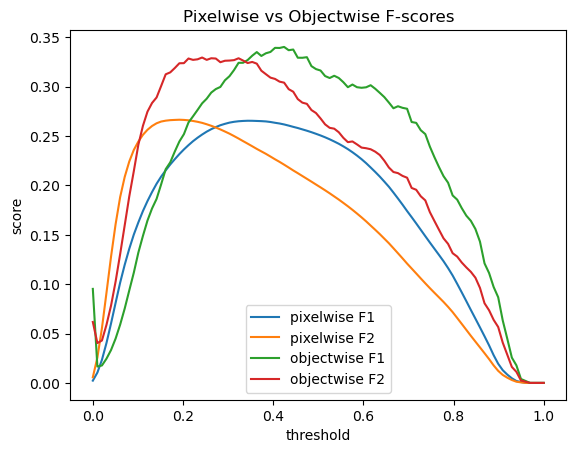

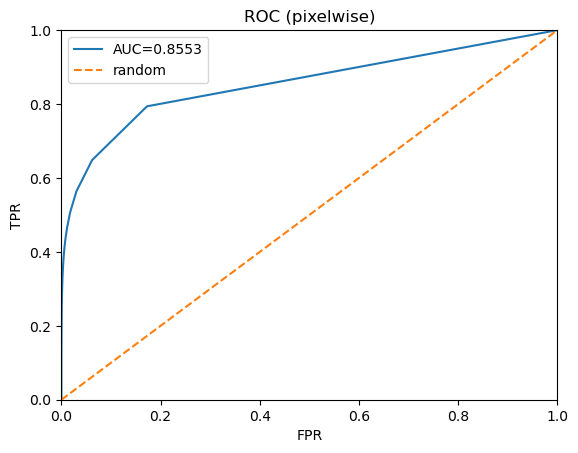

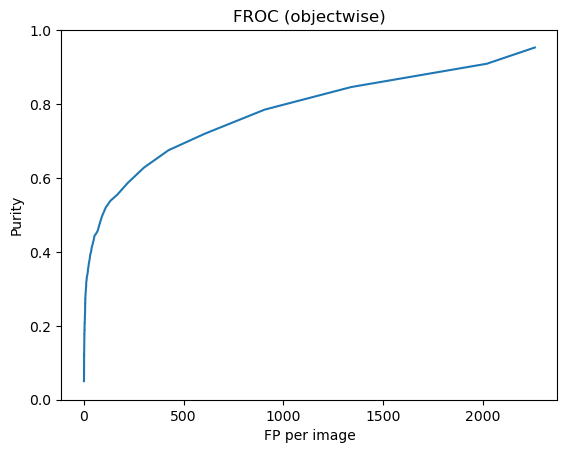

Pixel-wise Confusion Matrix
F1 Score: 0.2624, F2 Score: 0.2546
                 Predicted Negative  Predicted Positive
Actual Negative           812850730              612044
Actual Positive              703247              233979

Object-wise Confusion Matrix
F1 Score: 0.3104, F2 Score: 0.3281
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                 856
Actual Positive                 659                 341



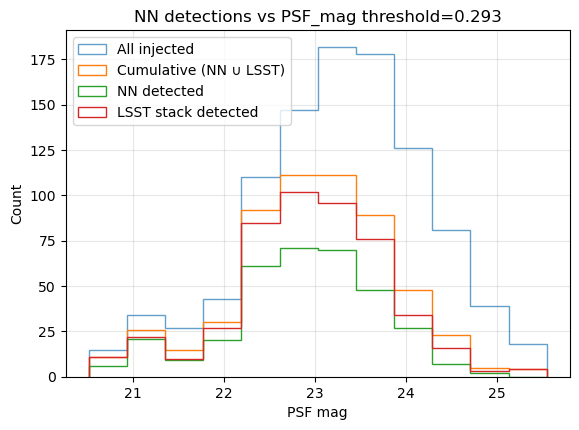

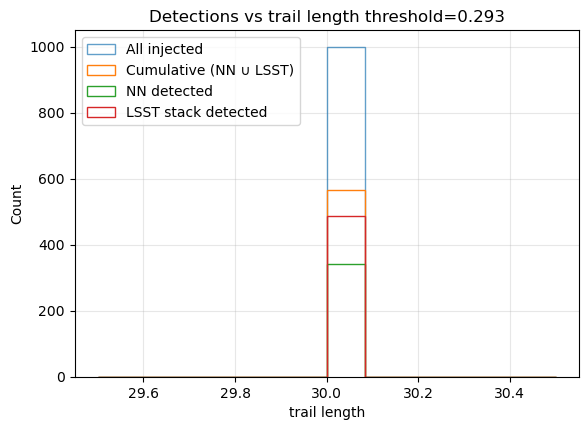

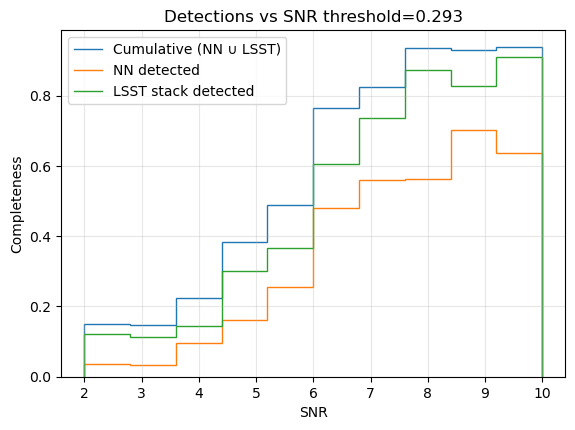

In [30]:
cat, _ = calculate_model_metrics(test_catalog, p, gt_test, best_threshold=best_thr, stack_fp=stack_fp)
#del (p_baseline_6sigma, test_loader_6sigma, test_catalog_6sigma, gt_test_6sigma, stack_fp_6sigma)
#_ = gc.collect()
#torch.cuda.empty_cache()

## Len = 50 pixels

### LSST Stack

In [31]:
_, test_loader, test_catalog, gt_test, stack_fp = load_test_data("../DATA/2_10s_50_50_l/test.h5",
                                                                 "../DATA/2_10s_50_50_l/test.csv", tile=128, k_sigma=5.0, batch_size=128)
print("6 SIGMA TEST SET - LSST STACK METRICS")
evals.print_confusion_matrix(get_stack_metrics (test_catalog, stack_fp), title="Object-wise Confusion Matrix")

6 SIGMA TEST SET - LSST STACK METRICS
Object-wise Confusion Matrix
F1 Score: 0.0060, F2 Score: 0.0147
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>              133679
Actual Positive                 594                 406



### Baseline Model

In [32]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p= predict_tiles_to_full("../DATA/2_10s_50_50_l/test.h5", test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
del (model_baseline)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


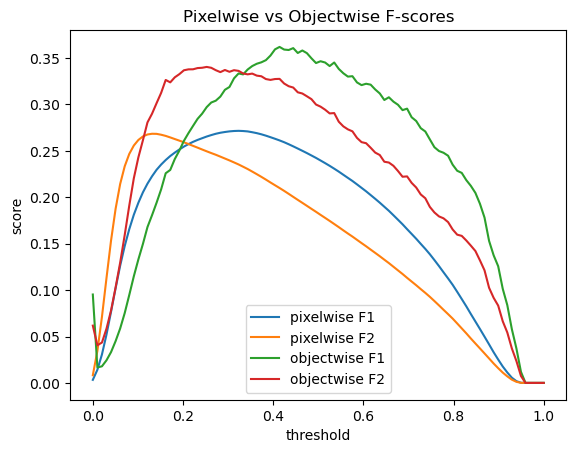

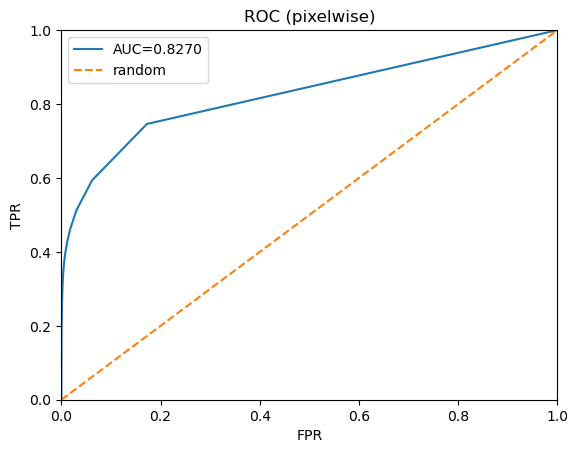

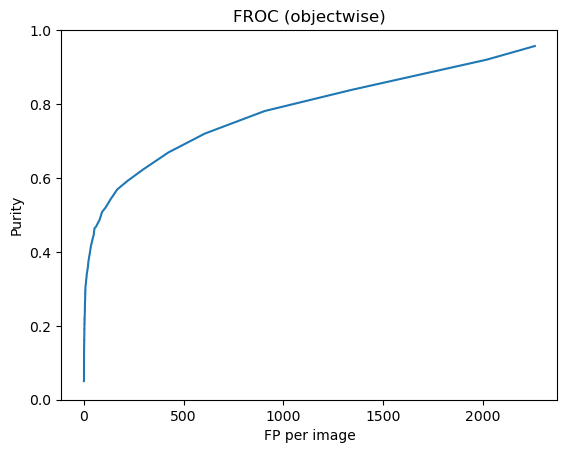

Pixel-wise Confusion Matrix
F1 Score: 0.2703, F2 Score: 0.2417
                 Predicted Negative  Predicted Positive
Actual Negative           812445606              601580
Actual Positive             1047419              305395

Object-wise Confusion Matrix
F1 Score: 0.3202, F2 Score: 0.3391
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                 852
Actual Positive                 647                 353



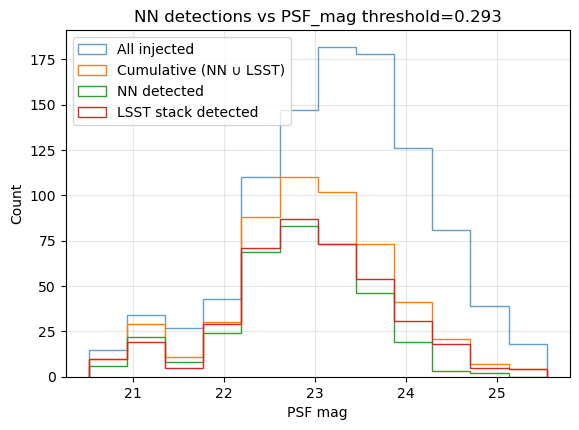

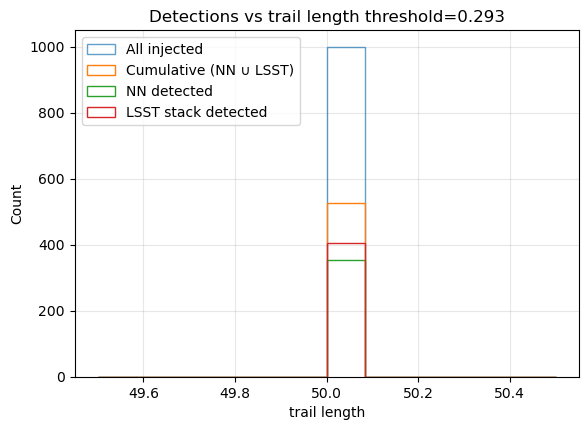

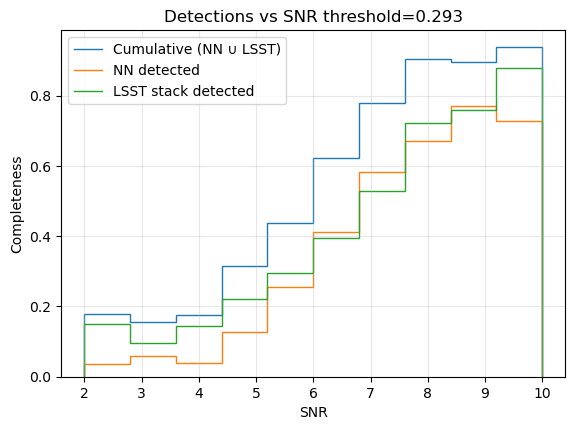

In [33]:
cat, _ = calculate_model_metrics(test_catalog, p, gt_test, best_threshold=best_thr, stack_fp=stack_fp)
#del (p_baseline_6sigma, test_loader_6sigma, test_catalog_6sigma, gt_test_6sigma, stack_fp_6sigma)
#_ = gc.collect()
#torch.cuda.empty_cache()